In [45]:
import pandas as pd
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
import random


SyntaxError: invalid syntax (1312104539.py, line 10)

In [2]:
points_for_win = 3
points_for_draw = 1
points_for_loss = 0
num_simulations = 10000

In [3]:
def expected_score(elo_a, elo_b):
    return 1 / (1 + 10 ** ((elo_b - elo_a) / 400))

def update_elo(elo_a, elo_b, result_a, k=20):
    exp_a = expected_score(elo_a, elo_b)
    new_elo_a = elo_a + k * (result_a - exp_a)
    new_elo_b = elo_b + k * ((1 - result_a) - (1 - exp_a))
    return new_elo_a, new_elo_b

In [4]:
def simulate_match(elo_a, elo_b):
    prob_a = expected_score(elo_a, elo_b)
    return 1 if random.random() < prob_a else 0

In [5]:
def calculate_elos(previous_games, k=20, initial_elo=1500):
    import math
    from collections import defaultdict

    elo_dict = defaultdict(lambda: initial_elo)
    game_count = defaultdict(int)

    for game in previous_games:
        team1, team2, score1, score2 = game
        score1, score2 = int(score1), int(score2)
        
        
        elo1 = elo_dict[team1]
        elo2 = elo_dict[team2]

        
        expected1 = 1 / (1 + 10 ** ((elo2 - elo1) / 400))
        expected2 = 1 - expected1

        
        if score1 > score2:
            actual1, actual2 = 1, 0
        elif score1 < score2:
            actual1, actual2 = 0, 1
        else:
            actual1 = actual2 = 0.5

        
        elo_dict[team1] += k * (actual1 - expected1)
        elo_dict[team2] += k * (actual2 - expected2)

        
        game_count[team1] += 1
        game_count[team2] += 1

    
    sd_dict = {team: 60 / math.sqrt(game_count[team]) if game_count[team] > 0 else 100 for team in elo_dict}

    return dict(elo_dict), sd_dict

In [6]:
def simulate_match_outcomes(elo_dict, sd_dict, remaining_matches, num_simulations=10000):
    match_outcomes = []
    elo_differences_over_time = [] 

    for match_id, match in enumerate(remaining_matches):  
        team_a = match['team_A']
        team_b = match['team_B']
        
        a_wins = 0
        b_wins = 0
        ties = 0
        total_goals_a = 0
        total_goals_b = 0

        for sim_id in range(num_simulations):
            elo_a = np.random.normal(elo_dict[team_a], sd_dict[team_a])
            elo_b = np.random.normal(elo_dict[team_b], sd_dict[team_b])

            
            elo_diff = elo_a - elo_b
            elo_differences_over_time.append({
                'match_id': match_id,  
                'elo_diff': elo_diff,
                'team_a': team_a,
                'team_b': team_b,
                'sim_id': sim_id
            })

            
            expected_goals_a = 1.5 + (elo_a - elo_b) / 400  
            expected_goals_b = 1.5 + (elo_b - elo_a) / 400

            expected_goals_a = max(expected_goals_a, 0.1)
            expected_goals_b = max(expected_goals_b, 0.1)

            score_a = poisson.rvs(expected_goals_a)
            score_b = poisson.rvs(expected_goals_b)

            total_goals_a += score_a
            total_goals_b += score_b

            if score_a > score_b:
                a_wins += 1
            elif score_b > score_a:
                b_wins += 1
            else:
                ties += 1

        match_outcomes.append({
            'Team A': team_a,
            'Team B': team_b,
            'Team A Win %': round(100 * a_wins / num_simulations, 2),
            'Draw %': round(100 * ties / num_simulations, 2),
            'Team B Win %': round(100 * b_wins / num_simulations, 2),
            'Avg Goals A': round(total_goals_a / num_simulations, 2),
            'Avg Goals B': round(total_goals_b / num_simulations, 2)
        })

    
    elo_diff_df = pd.DataFrame(elo_differences_over_time)
    return pd.DataFrame(match_outcomes), elo_diff_df

In [7]:
def get_current_stats(previous_games_list):
    current_points = defaultdict(int)
    games_played = defaultdict(int)

    for row in previous_games_list:
        team_a, team_b, score_a, score_b = row
        score_a = int(score_a)
        score_b = int(score_b)

        games_played[team_a] += 1
        games_played[team_b] += 1

        if score_a > score_b:
            current_points[team_a] += 3
        elif score_b > score_a:
            current_points[team_b] += 3
        else:
            current_points[team_a] += 1
            current_points[team_b] += 1

    return current_points, games_played

In [8]:
def simulate_group(elo_dict, sd_dict, remaining_matches, current_points, games_played, group_label, num_simulations=10000):
    teams = list(elo_dict.keys())
    results = []

    for sim_id in range(num_simulations):
        sim_elos = {team: np.random.normal(elo_dict[team], sd_dict[team]) for team in teams}
        sim_points = defaultdict(int, current_points)
        sim_games = defaultdict(int, games_played)

        for match in remaining_matches:
            team_a = match['team_A']
            team_b = match['team_B']

            if team_a not in sim_elos or team_b not in sim_elos:
                continue

            elo_a = sim_elos[team_a]
            elo_b = sim_elos[team_b]
            prob_a_win = 1 / (1 + 10 ** ((elo_b - elo_a) / 400))
            outcome = np.random.rand()

            sim_games[team_a] += 1
            sim_games[team_b] += 1

            if outcome < prob_a_win - 0.1:
                sim_points[team_a] += 3
            elif outcome > prob_a_win + 0.1:
                sim_points[team_b] += 3
            else:
                sim_points[team_a] += 1
                sim_points[team_b] += 1

        for team in teams:
            results.append({
                'Sim': sim_id,
                'Group': group_label,
                'Team': team,
                'Points': sim_points[team],
                'Games': sim_games[team],
                'PPG': sim_points[team] / sim_games[team] if sim_games[team] > 0 else 0
            })

    return pd.DataFrame(results)


In [9]:
def compute_points_from_played(played_matches):
    from collections import defaultdict
    points = defaultdict(int)
    games_played = defaultdict(int)

    
    if isinstance(played_matches, pd.DataFrame):
        match_iter = played_matches.to_dict(orient='records')
    else:
        match_iter = played_matches

    for match in match_iter:
        team_a = match['team_A']
        team_b = match['team_B']
        score_a = match['score_A']
        score_b = match['score_B']

        games_played[team_a] += 1
        games_played[team_b] += 1

        if score_a > score_b:
            points[team_a] += 3
        elif score_b > score_a:
            points[team_b] += 3
        else:  
            points[team_a] += 1
            points[team_b] += 1

    return points, games_played

In [10]:
def compute_qualification_probabilities(elo_dict, sd_dict, remaining_matches, played_matches, num_simulations=10000):
    qualification_counts = {team: 0 for team in elo_dict.keys()}
    results = []

    for sim_id in range(num_simulations):
        
        points, games_played = compute_points_from_played(played_matches)
        goals_for = {team: 0 for team in elo_dict.keys()}
        goals_against = {team: 0 for team in elo_dict.keys()}

        
        for match in remaining_matches:
            team_a = match['team_A']
            team_b = match['team_B']

            elo_a = np.random.normal(elo_dict[team_a], sd_dict[team_a])
            elo_b = np.random.normal(elo_dict[team_b], sd_dict[team_b])
            prob_a_win = 1 / (1 + 10 ** ((elo_b - elo_a) / 400))
            prob_b_win = 1 - prob_a_win

            outcome = np.random.choice(['A', 'Tie', 'B'], p=[prob_a_win * 0.9, 0.1, prob_b_win * 0.9])

            
            if outcome == 'A':
                points[team_a] += 3
                goals_for[team_a] += 2
                goals_against[team_b] += 2
                goals_for[team_b] += 0
                goals_against[team_a] += 0
            elif outcome == 'B':
                points[team_b] += 3
                goals_for[team_b] += 2
                goals_against[team_a] += 2
                goals_for[team_a] += 0
                goals_against[team_b] += 0
            else:  # Tie
                points[team_a] += 1
                points[team_b] += 1
                goals_for[team_a] += 1
                goals_for[team_b] += 1
                goals_against[team_a] += 1
                goals_against[team_b] += 1

            games_played[team_a] += 1
            games_played[team_b] += 1

        ppg = {team: points[team] / games_played[team] for team in points}
        
        sorted_teams = sorted(ppg.items(), key=lambda x: (-x[1], x[0]))
        top_8 = [team for team, _ in sorted_teams[:8]]

        for team in top_8:
            qualification_counts[team] += 1

        
        for team in points:
            results.append({
            'Team': team,
            'SimPoints': points[team],
            'SimGames': games_played[team],
            'PPG': points[team] / games_played[team],
            'GoalsFor': goals_for[team],
            'GoalsAgainst': goals_against[team],
            'Qualified': team in top_8  
        })

    qualification_probs = {team: qualification_counts[team] / num_simulations for team in elo_dict.keys()}
    results_df = pd.DataFrame(results)

    return qualification_probs, results_df

In [11]:
def parse_played_matches_df(df):
    parsed = []
    for _, row in df.iterrows():
        if row['score_A'] > row['score_B']:
            result = 'A'
        elif row['score_B'] > row['score_A']:
            result = 'B'
        else:
            result = 'Tie'

        parsed.append({
            'team_A': row['team_A'],
            'team_B': row['team_B'],
            'result': result
        })

    return parsed

In [12]:
def display_qualification_probs(title, qual_probs):
    print(f"=== {title} ===")
    df = pd.DataFrame(list(qual_probs.items()), columns=["Team", "Qualification Probability"])
    df["Qualification Probability"] = (df["Qualification Probability"] * 100).round(1).astype(str) + "%"
    display(df.sort_values("Qualification Probability", ascending=False).reset_index(drop=True))

In [13]:
def get_final_standings(sim_df, num_simulations):
    grouped = sim_df.groupby('Team').agg({'Points': 'sum', 'Games': 'sum'}).reset_index()
    grouped['AvgPoints'] = grouped['Points'] / num_simulations
    grouped['AvgGames'] = grouped['Games'] / num_simulations
    grouped['PPG'] = grouped['AvgPoints'] / grouped['AvgGames']
    return grouped.sort_values(by='PPG', ascending=False)



In [14]:
previous_games_group_A=[['CVSA Blue', 'Beadling White', '0', '0'],
               ['Steel City', 'Cleveland Force', '9', '1'],
                ['Ambassadors','Century Silver','1','2'],
                ['Century Gold','North FC Hudson','3','0'],
                ['Steel City','CVSA Blue','3','0'],
                ['North FC Hudson','Beadling White','0','6'],
                ['Ambassadors','Century Gold','0','4'],
                ['Cleveland Force','Century Silver','0','7'],
                ['CVSA Blue','Ambassadors','3','1'],
                ['Century Gold','Beadling White','0','1'],
                ['Beadling White','Century Silver','5','0'],
                ['Steel City','Century Gold','3','0'],
                ['North FC Hudson','Cleveland Force','1','2'],
                ['CVSA Blue','North FC Hudson','1','0'],
                ['Century Silver','Steel City','1','2'],
                ['Century Gold','Century Silver','3','2'],
                ['Cleveland Force','CVSA Blue','2','2'],
                ['Beadling White','Steel City','1','2'],
                ['Cleveland Force','Ambassadors','2','0'],
                ['Steel City','North FC Hudson','3','2'],
                ['Century Gold','Cleveland Force','3','2'],
                ['Century Gold','CVSA Blue','0','0'],
                ['North FC Hudson','Century Silver','0','3'],
                ['Century Silver','CVSA Blue','0','1'],
                ['Beadling White','Cleveland Force','1','0'],
                ['Cleveland Force','Beadling White','2','2'],
                ['CVSA Blue','Century Silver','1','1'],
                ['North FC Hudson','Century Gold','2','2'],
                ['Beadling White','CVSA Blue','0','1'],
                ['Cleveland Force','Steel City','1','4'],
                ['Century Silver','Ambassadors','1','1'],
                ['CVSA Blue','Steel City','1','3'],
                ['Beadling White','North FC Hudson','0','1'],
                ['Century Gold','Ambassadors','1','0'],
                ['Century Silver','Cleveland Force','1','2'],
                ['Ambassadors','Cleveland Force','1','1'],
                ['North FC Hudson','CVSA Blue','0','0'],
                ['Century Silver','North FC Hudson','1','2'],
                ['Cleveland Force','North FC Hudson','3','1'],
                ['Steel City','Ambassadors','5','1'], 
                ['Century Silver','Beadling White','1','2'],
                ['Ambassadors','Steel City','1','5'],
                ['North FC Hudson','Ambassadors','0','2'],
                ['Ambassadors','CVSA Blue','0','2'],   
                ['Ambassadors','Beadling White','4','1'],
                ['Century Gold','Cleveland Force','0','1'],
                ['Steel City','North FC Hudson','5','0'], 
                ['Century Gold','Steel City','0','1'],
                ['Beadling White','Ambassadors','1','2'],
                ['CVSA Blue','Cleveland Force','0','1'],
                ['CVSA Blue','Century Gold','0','1'],
                ['Beadling White','Century Gold','1','0'],
                #['Century Gold','Century Silver','0','0']
                ['Beadling White','Steel City','1','0']
               ]

previous_games_group_B=[['Cleveland Cobras','Erie FC','2','1'],
                       ['North FC West','Erie FC','0','2'],
                       ['Internationals','Northern Steel','0','2'],
                       ['Century Red','Cleveland Cobras','1','3'],
                       ['North FC West','Steel City Metro','4','1'],
                       ['FC Pittsburgh','Erie FC','0','2'],
                        ['Northern Steel','Cleveland Cobras','1','0'],
                       ['Erie FC','Beadling SCS','1','3'],
                        ['Internationals','Century Red','0','0'],
                       ['FC Pittsburgh','North FC West','3','1'],
                        ['Century Red','Beadling SCS','0','1'],
                       ['North FC West','Cleveland Cobras','1','6'],
                        ['Century Red','Erie FC','2','0'],
                       ['Erie FC','Northern Steel','1','5'],
                        ['FC Pittsburgh','Internationals','0','1'],
                       ['Steel City Metro','Northern Steel','0','3'],
                        ['Internationals','Beadling SCS','0','2'],
                       ['Cleveland Cobras','North FC West','5','0'],
                        ['Internationals','Erie FC','2','2'],
                       ['Erie FC','Century Red','2','3'],
                        ['Internationals','North FC West','0','6'],
                       ['Northern Steel','Century Red','3','0'],
                        ['Century Red','North FC West','4','0'],
                       ['Century Red','FC Pittsburgh','2','0'],
                        ['Century Red','Steel City Metro','2','0'],
                       ['Beadling SCS','Northern Steel','1','1'],
                        ['Internationals','Cleveland Cobras','0','5'],
                       ['Cleveland Cobras','Beadling SCS','2','3'],
                        ['Internationals','Steel City Metro','2','1'],
                       ['Northern Steel','North FC West','9','0'],
                        ['Beadling SCS','Internationals','2','0'],
                       ['Cleveland Cobras','Steel City Metro','6','3'],
                        ['Steel City Metro','Beadling SCS','1','3'],
                        ['Erie FC','FC Pittsburgh','2','3'],
                        ['Cleveland Cobras','Century Red','1','6'],
                        ['Northern Steel','Internationals','6','0'],
                        ['Century Red','Internationals','1','0'],
                        ['North FC West','FC Pittsburgh','5','0'],
                        ['Beadling SCS','Erie FC','5','0'],
                        ['Cleveland Cobras','Northern Steel','0','4'],
                        ['FC Pittsburgh','Century Red','0','1'],
                        ['Cleveland Cobras','Internationals','3','2'],
                        ['Northern Steel','Erie FC','2','0'],
                        ['Erie FC','Internationals','3','2'],
                        ['Beadling SCS','FC Pittsburgh','8','0']
                       ]

previous_games_group_C=[['Ohio Premier','GTFC Impact','2','3'],
                        ['Ohio Premier','Club Ohio Regional','1','0'],
                        ['Club Ohio North','Worthington United','0','0'],
                        ['Columbus Force','Manta United','0','8'],
                        ['Elite FC','Ohio Premier','3','0'],
                        ['Ohio Strikers','Club Ohio Regional','0','0'],
                        ['Worthington United','Ohio Strikers','3','0'],
                        ['Club Ohio North','Columbus Force','7','0'],
                        ['Manta United','Elite FC','7','0'],
                        ['GTFC Impact','Worthington United','1','0'],
                        ['Club Ohio Regional','Columbus Force','3','1'],
                        ['GTFC Impact','Elite FC','0','1'],
                        ['Ohio Premier','Club Ohio North','2','4'],
                        ['Worthington United','Manta United','0','3'],
                        ['Ohio Strikers','Columbus Force','2','0'],
                        ['Ohio Strikers','Club Ohio North','1','1'],
                        ['Worthington United','Elite FC','0','1'],
                        ['Club Ohio Regional','GTFC Impact','1','2'],
                        ['Ohio Premier','Manta United','1','5'],
                        ['Manta United','GTFC Impact','4','0'],
                        ['Ohio Premier','Columbus Force','5','0'],
                        ['Elite FC','Columbus Force','1','1'],
                        ['Columbus Force','Worthington United','0','1'],
                        ['Club Ohio Regional','Club Ohio North','0','4'],
                        ['Worthington United','Club Ohio North','4','5'],
                        ['GTFC Impact','Club Ohio North','2','2'],
                        ['Club Ohio North','Elite FC','1','0'],
                        ['Columbus Force','Club Ohio Regional','1','0'],
                        ['GTFC Impact','Ohio Strikers','1','0'],
                        ['Columbus Force','GTFC Impact','1','4'],
                        ['Ohio Strikers','Worthington United','1','0'],
                        ['Ohio Strikers','Elite FC','2','1'],
                        ['Elite FC','Club Ohio Regional','0','0'],
                        ['Manta United','Worthington United','4','1'],
                        ['GTFC Impact','Ohio Premier','2','1'],
                        ['Columbus Force','Ohio Strikers','0','3'],
                        ['Columbus Force','Ohio Premier','0','2'],
                        ['Worthington United','GTFC Impact','1','1'],
                        ['Club Ohio Regional','Manta United','0','11'],
                        ['Elite FC','Club Ohio North','0','4'],
                        ['Club Ohio North','Ohio Strikers','1','0'],
                        ['Club Ohio North','Club Ohio Regional','4','0'],
                        ['GTFC Impact','Manta United','1','5'],
                        ['Manta United','Columbus Force','3','0'],
                        ['Manta United','Club Ohio Regional','0','3'], #Forfeit
                        ['GTFC Impact','Club Ohio Regional','11','1'],
                        ['Club Ohio North','GTFC Impact','0','0'],
                        ['Manta United','Ohio Strikers','4','0'],
                        ['Ohio Strikers','Manta United','0','1'],
                        ['Elite FC','Ohio Strikers','0','2'],
                        ['GTFC Impact','Columbus Force','7','0'],
                        ['Worthington United','Club Ohio Regional','3','3'],
                        ['Elite FC','GTFC Impact','0','3']
                       ]


In [15]:
all_games = previous_games_group_A + previous_games_group_B + previous_games_group_C
elo_dict, sd_dict = calculate_elos(all_games)
teams = list(elo_dict.keys())

In [16]:
remaining_matches_group_A = [

    #{'team_A': 'Steel City', 'team_B': 'Beadling White'},
    {'team_A': 'Ambassadors', 'team_B': 'North FC Hudson'},
    {'team_A': 'Century Silver', 'team_B': 'Century Gold'},
    
    #{'team_A': 'CVSA Blue', 'team_B': 'Century Gold'},
    #{'team_A': 'CVSA Blue', 'team_B': 'Cleveland Force'}
]

remaining_matches_group_B =[
    {'team_A': 'Beadling SCS', 'team_B': 'Steel City Metro'},
    {'team_A': 'Beadling SCS', 'team_B': 'North FC West'},
    {'team_A': 'Steel City Metro', 'team_B': 'FC Pittsburgh'},
    {'team_A': 'North FC West','team_B':'Beadling SCS'},
    {'team_A': 'Internationals', 'team_B': 'FC Pittsburgh'},
    {'team_A': 'Steel City Metro', 'team_B': 'Cleveland Cobras'},
    {'team_A': 'Erie FC', 'team_B': 'North FC West'},
    {'team_A': 'Steel City Metro', 'team_B': 'North FC West'},
    {'team_A': 'Beadling SCS', 'team_B': 'Century Red'},
    {'team_A': 'Erie FC', 'team_B': 'Steel City Metro'},
    {'team_A': 'FC Pittsburgh', 'team_B': 'Cleveland Cobras'},
    {'team_A': 'Cleveland Cobras', 'team_B': 'FC Pittsburgh'},
    {'team_A': 'Northern Steel', 'team_B': 'Steel City Metro'},
    {'team_A': 'North FC West', 'team_B': 'Internationals'},
    {'team_A': 'Northern Steel', 'team_B': 'FC Pittsburgh'},
    {'team_A': 'Beadling SCS', 'team_B': 'Cleveland Cobras'},
    {'team_A': 'Steel City Metro', 'team_B': 'Erie FC'},
    {'team_A': 'North FC West', 'team_B': 'Northern Steel'},
    {'team_A': 'Steel City Metro', 'team_B': 'Internationals'},
    {'team_A': 'Northern Steel', 'team_B': 'Beadling SCS'},
    {'team_A': 'North FC West', 'team_B': 'Century Red'},
    {'team_A': 'Erie FC', 'team_B': 'Cleveland Cobras'},
    {'team_A': 'Steel City Metro', 'team_B': 'Century Red'},
    {'team_A': 'Century Red', 'team_B': 'Northern Steel'},
    {'team_A': 'FC Pittsburgh', 'team_B': 'Beadling SCS'},
    {'team_A': 'FC Pittsburgh', 'team_B': 'Steel City Metro'},
    {'team_A': 'FC Pittsburgh', 'team_B': 'Northern Steel'}
]
remaining_matches_group_C=[
    {'team_A': 'Manta United', 'team_B': 'Club Ohio North'},
    {'team_A': 'Ohio Premier', 'team_B': 'Ohio Strikers'},
    {'team_A': 'Club Ohio Regional', 'team_B': 'Elite FC'},
    {'team_A': 'Manta United', 'team_B': 'Ohio Premier'},
    {'team_A': 'Columbus Force', 'team_B': 'Elite FC'},
    {'team_A': 'Elite FC', 'team_B': 'Worthington United'},
    {'team_A': 'Ohio Premier', 'team_B': 'Worthington United'},
    {'team_A': 'Ohio Strikers', 'team_B': 'Ohio Premier'},
    {'team_A': 'Club Ohio Regional', 'team_B': 'Ohio Strikers'},
    {'team_A': 'Club Ohio North', 'team_B': 'Ohio Premier'},
    {'team_A': 'Worthington United', 'team_B': 'Columbus Force'},
    {'team_A': 'Club Ohio Regional', 'team_B': 'Ohio Premier'},
    {'team_A': 'Columbus Force', 'team_B': 'Club Ohio North'},
    {'team_A': 'Elite FC', 'team_B': 'Manta United'},
    {'team_A': 'Worthington United', 'team_B': 'Ohio Premier'},
    {'team_A': 'Ohio Strikers', 'team_B': 'GTFC Impact'},
    {'team_A': 'Club Ohio North', 'team_B': 'Manta United'},
    {'team_A': 'Club Ohio Regional', 'team_B': 'Worthington United'},
    {'team_A': 'Ohio Premier', 'team_B': 'Elite FC'}
]


In [17]:
def make_clean_df(match_list):
    if isinstance(match_list, pd.DataFrame):
        return match_list  # already clean
    df = pd.DataFrame(match_list, columns=['team_A', 'team_B', 'score_A', 'score_B'])
    df[['score_A', 'score_B']] = df[['score_A', 'score_B']].astype(int)
    return df

played_matches_group_A = make_clean_df(previous_games_group_A)
played_matches_group_B = make_clean_df(previous_games_group_B)
played_matches_group_C = make_clean_df(previous_games_group_C)

played_matches = pd.concat([
    played_matches_group_A,
    played_matches_group_B,
    played_matches_group_C
], ignore_index=True)

In [18]:
def flatten_match_lists(*groups):
    matches = []
    for group in groups:
        matches.extend(group)
    return matches

played_matches = flatten_match_lists(previous_games_group_A, previous_games_group_B, previous_games_group_C)

In [19]:
def create_match_df(matches):
    df = pd.DataFrame(matches, columns=['Team A', 'Team B', 'Score A', 'Score B'])
    df.columns = ['team_A', 'team_B', 'score_A', 'score_B']
    return df

previous_games_group_a = create_match_df(previous_games_group_A)
previous_games_group_b = create_match_df(previous_games_group_B)
previous_games_group_c = create_match_df(previous_games_group_C)

print(previous_games_group_a.columns)  
print(previous_games_group_a.iloc[0])

Index(['team_A', 'team_B', 'score_A', 'score_B'], dtype='object')
team_A          CVSA Blue
team_B     Beadling White
score_A                 0
score_B                 0
Name: 0, dtype: object


In [20]:

standings = defaultdict(lambda: {
    'Games Played': 0,
    'Wins': 0,
    'Draws': 0,
    'Losses': 0,
    'Goals For': 0,
    'Goals Against': 0,
    'Goal Difference': 0,
    'Points': 0
})


for game in previous_games_group_A:
    team_a, team_b, goals_a, goals_b = game
    goals_a = int(goals_a)
    goals_b = int(goals_b)

    
    standings[team_a]['Games Played'] += 1
    standings[team_b]['Games Played'] += 1

    
    standings[team_a]['Goals For'] += goals_a
    standings[team_a]['Goals Against'] += goals_b
    standings[team_b]['Goals For'] += goals_b
    standings[team_b]['Goals Against'] += goals_a

    
    if goals_a > goals_b:
        standings[team_a]['Wins'] += 1
        standings[team_b]['Losses'] += 1
        standings[team_a]['Points'] += 3
    elif goals_b > goals_a:
        standings[team_b]['Wins'] += 1
        standings[team_a]['Losses'] += 1
        standings[team_b]['Points'] += 3
    else:  
        standings[team_a]['Draws'] += 1
        standings[team_b]['Draws'] += 1
        standings[team_a]['Points'] += 1
        standings[team_b]['Points'] += 1


for team in standings:
    standings[team]['Goal Difference'] = (
        standings[team]['Goals For'] - standings[team]['Goals Against']
    )


standings_df = pd.DataFrame.from_dict(standings, orient='index').reset_index()
standings_df = standings_df.rename(columns={'index': 'Team'})


standings_df = standings_df.sort_values(
    by=['Points', 'Goal Difference', 'Goals For'],
    ascending=False
).reset_index(drop=True)


print(standings_df)


              Team  Games Played  Wins  Draws  Losses  Goals For  \
0       Steel City            13    12      0       1         45   
1   Beadling White            14     7      2       5         22   
2  Cleveland Force            14     6      3       5         20   
3     Century Gold            13     6      2       5         17   
4        CVSA Blue            14     5      5       4         12   
5   Century Silver            12     3      2       7         20   
6      Ambassadors            13     3      2       8         14   
7  North FC Hudson            13     2      2       9          9   

   Goals Against  Goal Difference  Points  
0             10               35      36  
1             13                9      23  
2             32              -12      21  
3             13                4      20  
4             12                0      20  
5             20                0      11  
6             28              -14      11  
7             31              -22  

In [21]:
K = 20
K_uncertainty = 300
initial_elo = 1500
elos = {}
games_played = {}

for game in previous_games_group_A:
    team_a, team_b, score_a, score_b = game
    score_a, score_b = int(score_a), int(score_b)

    for team in [team_a, team_b]:
        if team not in elos:
            elos[team] = initial_elo
            games_played[team] = 0

    elo_a = elos[team_a]
    elo_b = elos[team_b]

    exp_a = expected_score(elo_a, elo_b)
    exp_b = expected_score(elo_b, elo_a)

    
    if score_a > score_b:
        result_a, result_b = 1, 0
    elif score_a < score_b:
        result_a, result_b = 0, 1
    else:
        result_a = result_b = 0.5

    
    elos[team_a] += K * (result_a - exp_a)
    elos[team_b] += K * (result_b - exp_b)

    games_played[team_a] += 1
    games_played[team_b] += 1


elo_data = []
for team in elos:
    gp = games_played[team]
    sd = K_uncertainty / np.sqrt(gp) if gp > 0 else float('inf')
    elo_data.append([team, elos[team], gp, sd])

elo_df = pd.DataFrame(elo_data, columns=["Team", "ELO", "Games Played", "ELO_SD"])
elo_df = elo_df.sort_values(by="ELO", ascending=False).reset_index(drop=True)

print(elo_df)

              Team          ELO  Games Played     ELO_SD
0       Steel City  1587.441169            13  83.205029
1  Cleveland Force  1515.653739            14  80.178373
2   Beadling White  1514.786021            14  80.178373
3     Century Gold  1506.068353            13  83.205029
4        CVSA Blue  1504.714574            14  80.178373
5      Ambassadors  1467.384432            13  83.205029
6   Century Silver  1459.399208            12  86.602540
7  North FC Hudson  1444.552504            13  83.205029


100%|██████████| 10000/10000 [00:00<00:00, 10843.98it/s]
C:\Users\Adam\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Adam\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Adam\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Adam\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a futur

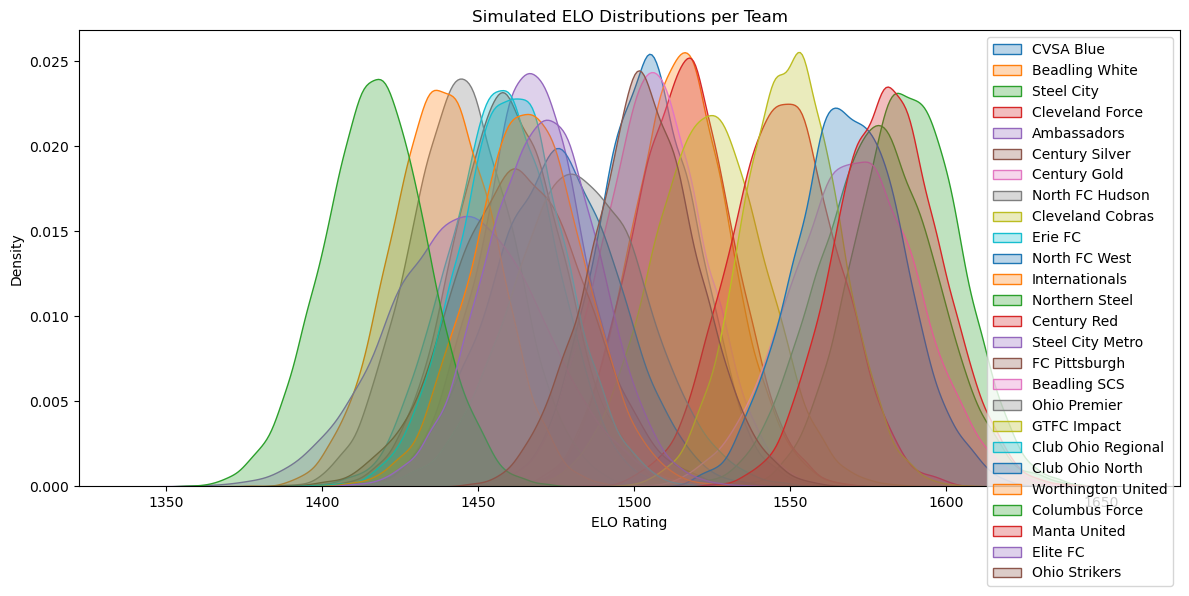

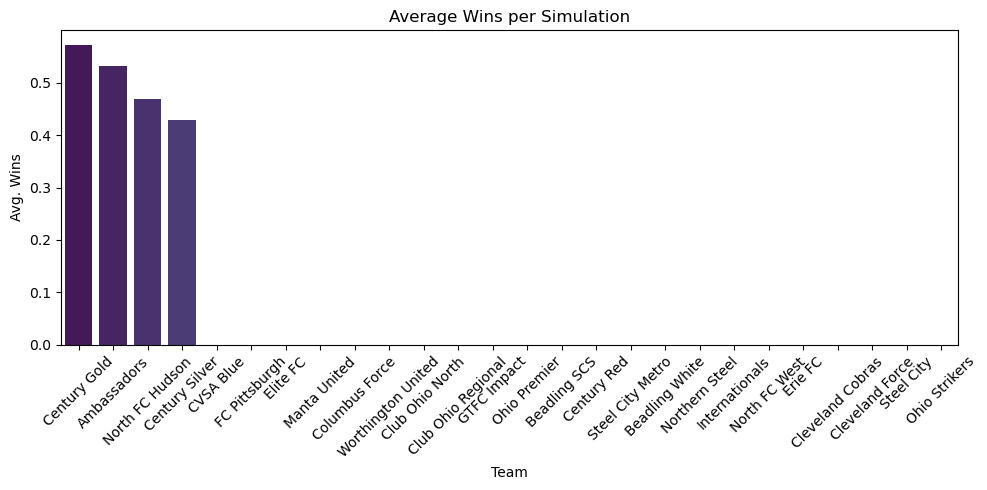

In [22]:

elo_draws = defaultdict(list)
win_counts = defaultdict(list)


for sim in tqdm(range(num_simulations)):
    sim_elos = {team: np.random.normal(elo_dict[team], sd_dict[team]) for team in teams}
    
    
    for team, elo in sim_elos.items():
        elo_draws[team].append(elo)

    
    sim_wins = defaultdict(int)

    for match in remaining_matches_group_A:
        team_a = match['team_A']
        team_b = match['team_B']
        elo_a = sim_elos[team_a]
        elo_b = sim_elos[team_b]

        prob_a_win = 1 / (1 + 10 ** ((elo_b - elo_a) / 400))
        prob_b_win = 1 - prob_a_win

        outcome = np.random.rand()
        if outcome < prob_a_win - 0.1:
            sim_wins[team_a] += 1
        elif outcome > prob_a_win + 0.1:
            sim_wins[team_b] += 1
        else:
            sim_wins[team_a] += 0.5
            sim_wins[team_b] += 0.5

    for team in teams:
        win_counts[team].append(sim_wins[team])

plt.figure(figsize=(12, 6))
for team in teams:
    sns.kdeplot(elo_draws[team], label=team, fill=True, alpha=0.3)
plt.title("Simulated ELO Distributions per Team")
plt.xlabel("ELO Rating")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


avg_wins = pd.DataFrame({
    'Team': teams,
    'Average Wins': [np.mean(win_counts[team]) for team in teams]
}).sort_values(by='Average Wins', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=avg_wins, x='Team', y='Average Wins', palette='viridis')
plt.xticks(rotation=45)
plt.title("Average Wins per Simulation")
plt.ylabel("Avg. Wins")
plt.xlabel("Team")
plt.tight_layout()
plt.show()

In [23]:

current_points_a, games_played_a = get_current_stats(previous_games_group_A)
current_points_b, games_played_b = get_current_stats(previous_games_group_B)
current_points_c, games_played_c = get_current_stats(previous_games_group_C)

In [24]:

columns = ['team_A', 'team_B', 'score_A', 'score_B']
df_A = pd.DataFrame(previous_games_group_A, columns=columns)
df_B = pd.DataFrame(previous_games_group_B, columns=columns)
df_C = pd.DataFrame(previous_games_group_C, columns=columns)


all_games_df = pd.concat([df_A, df_B, df_C])


def calculate_elos(previous_games_df, k=20, initial_elo=1500):
    import math
    from collections import defaultdict

    elo_dict = defaultdict(lambda: initial_elo)
    game_count = defaultdict(int)

    for _, row in previous_games_df.iterrows():
        team1 = row['team_A']
        team2 = row['team_B']
        score1, score2 = int(row['score_A']), int(row['score_B'])
        
        
        elo1 = elo_dict[team1]
        elo2 = elo_dict[team2]

        
        expected1 = 1 / (1 + 10 ** ((elo2 - elo1) / 400))
        expected2 = 1 - expected1

        
        if score1 > score2:
            actual1, actual2 = 1, 0
        elif score1 < score2:
            actual1, actual2 = 0, 1
        else:
            actual1 = actual2 = 0.5

        
        elo_dict[team1] += k * (actual1 - expected1)
        elo_dict[team2] += k * (actual2 - expected2)

        
        game_count[team1] += 1
        game_count[team2] += 1

    
    sd_dict = {team: 60 / math.sqrt(game_count[team]) if game_count[team] > 0 else 100 for team in elo_dict}

    return dict(elo_dict), sd_dict

In [25]:
previous_games_group_a = create_match_df(previous_games_group_A)
print(previous_games_group_a.columns)
print(previous_games_group_a.head(1))

Index(['team_A', 'team_B', 'score_A', 'score_B'], dtype='object')
      team_A          team_B score_A score_B
0  CVSA Blue  Beadling White       0       0


In [26]:

previous_games_df_A = pd.DataFrame(previous_games_group_A, columns=['team_A', 'team_B', 'score_A', 'score_B'])
previous_games_df_B = pd.DataFrame(previous_games_group_B, columns=['team_A', 'team_B', 'score_A', 'score_B'])
previous_games_df_C = pd.DataFrame(previous_games_group_C, columns=['team_A', 'team_B', 'score_A', 'score_B'])


elo_dict_A, sd_dict_A = calculate_elos(previous_games_df_A)
elo_dict_B, sd_dict_B = calculate_elos(previous_games_df_B)
elo_dict_C, sd_dict_C = calculate_elos(previous_games_df_C)

In [27]:
elo_dict_A, sd_dict_A = calculate_elos(previous_games_df_A)
elo_dict_B, sd_dict_B = calculate_elos(previous_games_df_B)
elo_dict_C, sd_dict_C = calculate_elos(previous_games_df_C)



current_points_A, games_played_A = get_current_stats(previous_games_group_A)
current_points_B, games_played_B = get_current_stats(previous_games_group_B)
current_points_C, games_played_C = get_current_stats(previous_games_group_C)

In [28]:

sim_A = simulate_group(elo_dict_A, sd_dict_A, remaining_matches_group_A, current_points_A, games_played_A, num_simulations)
sim_B = simulate_group(elo_dict_B, sd_dict_B, remaining_matches_group_B, current_points_B, games_played_B, num_simulations)
sim_C = simulate_group(elo_dict_C, sd_dict_C, remaining_matches_group_C, current_points_C, games_played_C, num_simulations)


standings_A = get_final_standings(sim_A, num_simulations)
standings_B = get_final_standings(sim_B, num_simulations)
standings_C = get_final_standings(sim_C, num_simulations)


standings_A['Group'] = 'A'
standings_B['Group'] = 'B'
standings_C['Group'] = 'C'


all_standings = pd.concat([standings_A, standings_B, standings_C], ignore_index=True)


In [29]:

winners = all_standings.groupby('Group').first().reset_index()
winners_list = winners['Team'].tolist()


remaining_teams = all_standings[~all_standings['Team'].isin(winners_list)]


second_place_teams = all_standings.groupby('Group').nth(1).reset_index()


best_2nd = second_place_teams.sort_values(by='PPG', ascending=False).iloc[0]
nationals_teams = winners_list + [best_2nd['Team']]


regionals_second_place = second_place_teams[second_place_teams['Team'] != best_2nd['Team']]


third_place_teams = all_standings.groupby('Group').nth(2).reset_index()
best_third_place = third_place_teams.sort_values(by='PPG', ascending=False).head(2)

regionals_teams = regionals_second_place['Team'].tolist() + best_third_place['Team'].tolist()


In [30]:
print("Nationals Bracket:")
for team in nationals_teams:
    print(f"- {team}")

print("\nRegionals Bracket:")
for team in regionals_teams:
    print(f"- {team}")


Nationals Bracket:
- Steel City
- Northern Steel
- Manta United
- Beadling SCS

Regionals Bracket:
- Beadling White
- Club Ohio North
- GTFC Impact
- Century Red


In [31]:
def analyze_simulations(all_sims):
    from collections import defaultdict

    
    qualification_counts = defaultdict(lambda: {'Nationals': 0, 'Regionals': 0, 'Other': 0})

    for sim_id, group_df in all_sims.groupby('Sim'):
        
        group_standings = (
            group_df.sort_values(by=['Group', 'PPG'], ascending=[True, False])
            .groupby('Group')
            .head(3)
            .copy()
        )

        
        group_standings['Rank'] = group_standings.groupby('Group')['PPG'].rank(method='first', ascending=False)
        winners = group_standings[group_standings['Rank'] == 1]
        seconds = group_standings[group_standings['Rank'] == 2]
        thirds = group_standings[group_standings['Rank'] == 3]

        
        best_2nd = seconds.sort_values(by='PPG', ascending=False).iloc[0]
        remaining_2nds = seconds[seconds['Team'] != best_2nd['Team']]

        
        best_thirds = thirds.sort_values(by='PPG', ascending=False).head(2)

        
        nationals_teams = set(winners['Team']) | {best_2nd['Team']}
        regionals_teams = set(remaining_2nds['Team']) | set(best_thirds['Team'])

        
        all_teams = group_df['Team'].unique()
        for team in all_teams:
            if team in nationals_teams:
                qualification_counts[team]['Nationals'] += 1
            elif team in regionals_teams:
                qualification_counts[team]['Regionals'] += 1
            else:
                qualification_counts[team]['Other'] += 1

    
    total_sims = all_sims['Sim'].nunique()
    qualification_df = pd.DataFrame([
        {'Team': team,
         'Nationals_Odds': counts['Nationals'] / total_sims,
         'Regionals_Odds': counts['Regionals'] / total_sims,
         'Missed_Odds': counts['Other'] / total_sims}
        for team, counts in qualification_counts.items()
    ])

    return qualification_df.sort_values(by='Regionals_Odds', ascending=False)


In [32]:
sim_A['Group'] = 'A'
sim_B['Group'] = 'B'
sim_C['Group'] = 'C'


In [33]:
all_sims = pd.concat([sim_A, sim_B, sim_C], ignore_index=True)


In [34]:
qualification_odds = analyze_simulations(all_sims)
print(qualification_odds.round(3).to_string(index=False))


              Team  Nationals_Odds  Regionals_Odds  Missed_Odds
    Beadling White           0.000           1.000        0.000
       GTFC Impact           0.012           0.986        0.001
   Club Ohio North           0.351           0.647        0.002
       Century Red           0.096           0.591        0.313
  Cleveland Cobras           0.030           0.327        0.643
      Beadling SCS           0.719           0.236        0.045
    Northern Steel           0.882           0.111        0.007
      Manta United           0.909           0.091        0.000
      Century Gold           0.000           0.006        0.994
      Ohio Premier           0.000           0.002        0.998
     North FC West           0.000           0.001        0.999
     Ohio Strikers           0.000           0.000        1.000
     FC Pittsburgh           0.000           0.000        1.000
    Internationals           0.000           0.000        1.000
           Erie FC           0.000      

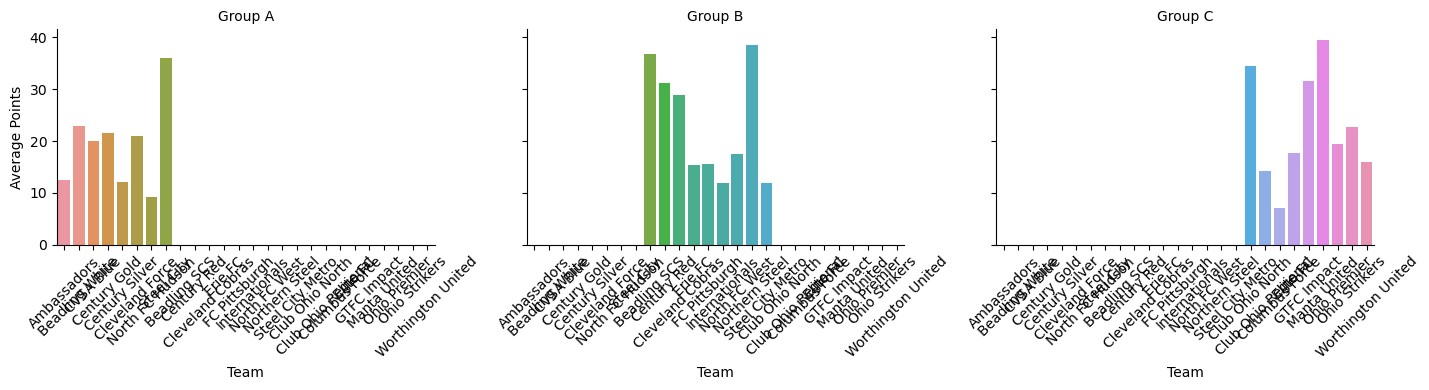

In [39]:
# Average points across simulations
avg_points = all_sims.groupby(['Group', 'Team'])['Points'].mean().reset_index()

g = sns.catplot(
    data=avg_points, kind='bar',
    x='Team', y='Points', col='Group', col_wrap=3,
    height=4, aspect=1.2
)
g.set_titles("Group {col_name}")
g.set_axis_labels("Team", "Average Points")
g.set_xticklabels(rotation=45)
plt.tight_layout()
plt.show()
